# Hebrew Study Notebook

In [1]:
import os, json
from pprint import pprint
import collections
from datetime import datetime
from IPython.display import display
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from iMahir import loadStudy

In [2]:
home_dir = os.path.expanduser('~/')
hebrew = os.path.join(home_dir, 'Documents/vocabulary/hebrew.json')

In [3]:
! date

Mon 14 Sep 2020 11:42:07 BST


In [4]:
heb = loadStudy(hebrew)

preparing TF...


hebrew ready for study.
this is session 11:
score 6: 5 terms
score 5: 13 terms
score 4: 30 terms
score 3: 196 terms
score 1: 23 terms
total: 267


In [5]:
heb.learn()

The following scores were changed 
1<-3 		 15
1->3 		 14
4<-5 		 2

duration:  0:20:46.390110

seconds per term: 4.67


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Study Stats

## Plot Number of Daily Demoted Terms

This plot should hopefully reflect a downward trend over time. But I expect
a spike in demoted terms initially since I've just crammed in 500 new terms
quickly.

In [6]:
from scipy.stats import linregress

# gather all sessions that contain necessary data
sessions = [
    session for session in heb.set_data['stats'] if 'score_counts' in session
]

# plot this data only with cutoff
cutoff = -30 # max amount
plt_sessions = sessions[cutoff:]

# gather term data for plot
n_demoted = []
n_promoted = []
n_review = []
for session in plt_sessions:
    
    demoted_tally = 0
    promoted_tally = 0
    for change, count in session['changes'].items():
        if '<-' in change:
            demoted_tally += count
        else:
            promoted_tally += count
    n_demoted.append(demoted_tally)
    n_promoted.append(promoted_tally)
    
    review_tally = 0
    for s, count in session['score_counts'].items():
        if 3 > int(s) > 0:
            review_tally += count
    n_review.append(review_tally)
    
# organize and simplify time stamps for plot
dates = [datetime.strptime(sd['date'], '%Y-%m-%d %H:%M:%S.%f') for sd in plt_sessions]
date_labels = [datetime.strftime(time, format='%d-%m_%H:%M') for time in dates]    
    
# calculate cycle lines
cycle_bounds = []
last_cycle = None
for i, sd in enumerate(plt_sessions):
    cycle = sd['cycle']
    last_cycle = cycle if not last_cycle else last_cycle
    if last_cycle != cycle:
        cycle_bounds.append(i-0.5)
        last_cycle = cycle

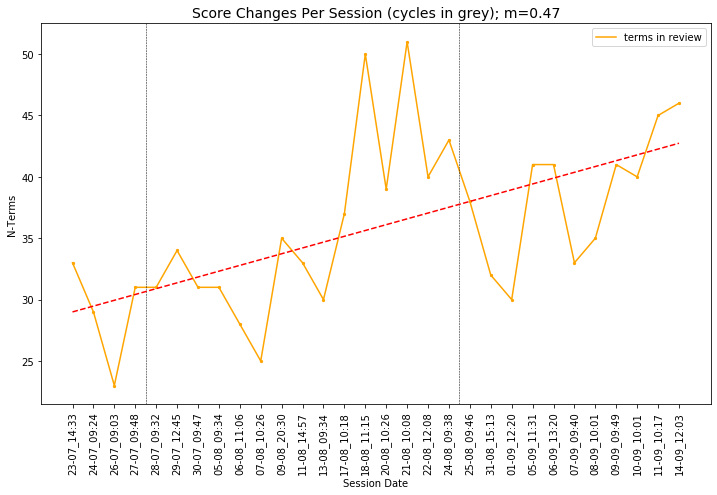

In [7]:
# setup for plot
x = np.arange(len(n_demoted))
fig, ax = plt.subplots(figsize=(12, 7))

# plot demoted
# ax.plot(x, n_demoted, color='red')
# ax.scatter(x, n_demoted, s=5, color='red')

# plot promoted
# ax.plot(x, n_promoted, color='green')
# ax.scatter(x, n_promoted, s=5, color='green')

# plot in-review terms
ax.plot(x, n_review, color='orange')
ax.scatter(x, n_review, s=5, color='orange')

# plot bounds
for bound in cycle_bounds:
    ax.axvline(bound, color='black', linestyle='--', linewidth=0.5)

# plot linear regression line on n_review
slope, intercept, r, p, err = linregress(x, n_review)
line_y = slope*x + intercept
color = 'red' if slope > 0 else 'green'
ax.plot(x, line_y, linestyle='--', color=color)

# plot details
ax.set_xticks(x)
ax.set_xticklabels(date_labels, rotation=90)
ax.set_title(f'Score Changes Per Session (cycles in grey); m={round(slope, 2)}', size=14)
ax.legend(['terms in review',]) #'promoted terms', 'demoted terms'])
ax.set_ylabel('N-Terms')
ax.set_xlabel('Session Date')

plt.show()

### Push Backup to Github

In [8]:
! cp /Users/cody/Documents/vocabulary/hebrew.json sample_vocab/.

In [9]:
! git add sample_vocab/.; git commit -m "Latest updates"

[master 1e16271] Latest updates
 1 file changed, 598 insertions(+), 570 deletions(-)


In [10]:
! git add study_HB.ipynb; git commit -m "Latest session"

[master 5d329f9] Latest session
 1 file changed, 19 insertions(+), 18 deletions(-)


In [11]:
! git push origin master

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 4 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 47.85 KiB | 2.39 MiB/s, done.
Total 7 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/codykingham/Mahir
   0860509..5d329f9  master -> master


# Overall Progress to Learn all Terms

The plot below shows my overall progress to learning all of the lexemes
in the Hebrew Bible (excluding proper names), as arranged in the ETCBC's
BHSA Hebrew Bible dataset, and as edited by me.

I have additional data going back further that has not yet been accounted for
in these values.

In [37]:
sessions_till_learned = sessions[:274]

# calculate total learned & unlearned for each session
# NB: since some terms were added later to the score 0 set,
# we adjust the counts of sessions before 2019-06-25, which
# reflect 2583 less terms than what would be added later
n_learned = []
n_unlearned = []
for i, session in enumerate(sessions_till_learned):
    learned_tally = 0
    for score, count in session['score_counts'].items():
        if score != '0':
            learned_tally += count
        else:
            if i < 39:
                # adjust unlearned count to include terms added later
                n_unlearned.append(count+2583)
            else:
                n_unlearned.append(count)
            
            
    n_learned.append(learned_tally)

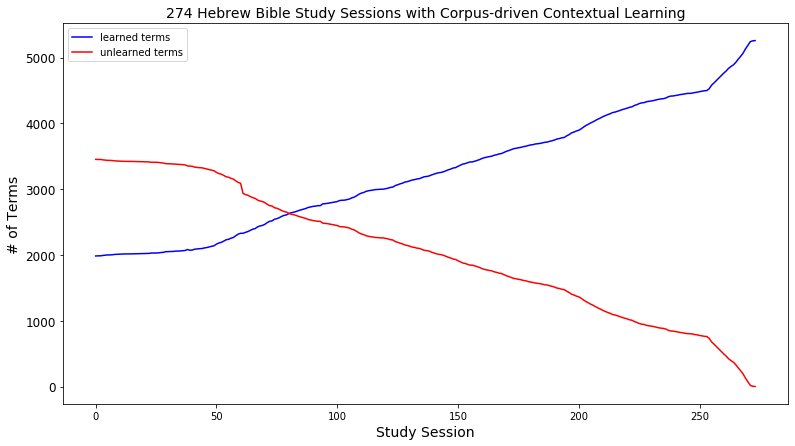

In [39]:
# make the plot
x = np.arange(len(n_learned))

# plot learned items
plt.figure(figsize=(13, 7))
blue_line = plt.plot(x, n_learned, color='blue')

# plot unlearned items
red_line = plt.plot(x, n_unlearned, color='red')

# modify ticks and labels
plt.yticks(size=12)
plt.ylabel('# of Terms', size=14)
plt.xlabel('Study Session', size=14)
plt.title(f'274 Hebrew Bible Study Sessions with Corpus-driven Contextual Learning', size=14)
plt.legend(['learned terms', 'unlearned terms'])
#plt.savefig('/Users/cody/Desktop/study_sessions.png', bbox_inches='tight', dpi=300)
plt.show()